In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.style.use('ggplot')

To associate harvest lat long with planting data, we calculate the row with the minimum eucledian distance from harvest data ( in terms of lat long values) and associate planting values with that row. 

In [4]:
def assoc_harvest_points(planting_file, harvest_file):
    
    planting = pd.read_csv(planting_file)
    harvest = pd.read_csv(harvest_file)
    
    def find_closest_plant(hr):
        lat = hr.lat
        long = hr.long
        dists = np.sqrt(np.square(planting.lat - lat) + np.square(planting.long - long))
        #p = planting.iloc(np.argmin(dists),['variety', 'seeding_rate', 'seed_spacing', 'speed'])
        p = planting.iloc[np.argmin(dists)][['variety', 'seeding_rate', 'seed_spacing', 'speed']]
        return p

    planting_join = harvest.apply(find_closest_plant, axis=1)
    harvest_mapped = pd.concat([harvest, planting_join], axis=1)
    return harvest_mapped, harvest, planting

In [5]:
planting_file = 'planting_sample_data.csv'
harvest_file = 'harvest_sample_data.csv'

harvest_mapped, harvest, planting = assoc_harvest_points(planting_file, harvest_file)

In [6]:
def plot_harvest_yeilds(harvest_full):
    #harvest = harvest_full.sample(n=10)    
    harvest = harvest_full
    harvest.sort_values(['lat','long'], ascending=[True,True])
    #print(harvest)
    X = harvest.lat
    Y = harvest.long
    Z = harvest['yield']
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Yeild')
    ax.set_title("Yield plot for harvest")
    plt.show()
    
    
def plot_planting(planting, col):
    
    X = planting.lat
    Y = planting.long
    Z = planting[col]
    planting.color = ['r' if x=='P1498' else 'g' for x in planting.variety]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, color=planting.color)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel(col)
    ax.set_title(col + " plot for Planting")
    plt.show()

I have plotted the yield value as a scatter plot where the x, y axes are lat and long. The plot shows a nearly uniform distribution of yields with a slight apparant increase towards to edges. Not easily interpretable. 

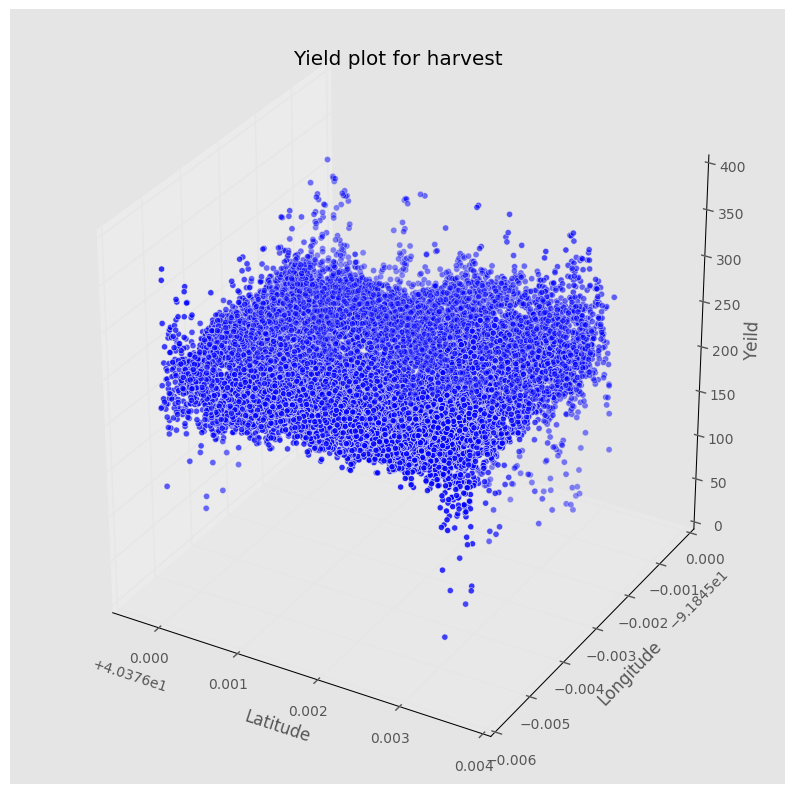

In [7]:
plot_harvest_yeilds(harvest)

Plotted the seeding rate as a function of lat long similar to last plot with variety marked a different colors. Plot shows one variety to be concentrated towards the edges of the area under analysis. 

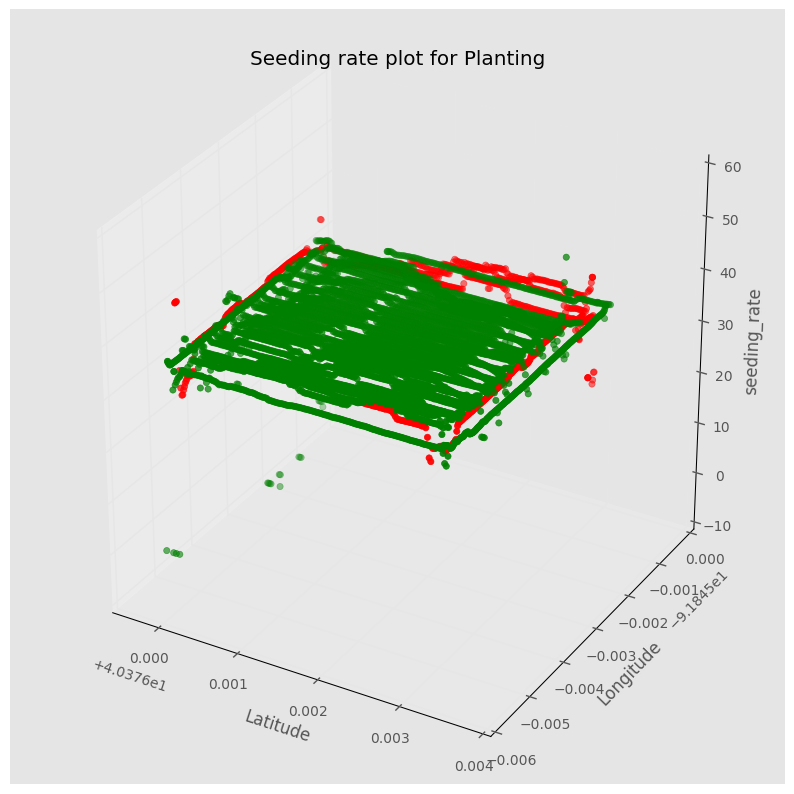

In [22]:
plot_planting(planting, 'seeding_space')

In [10]:
harvest_mapped.head()

,long,lat,yield,variety,seeding_rate,seed_spacing,speed
0,-91.849991,40.376097,88.451156,DKC63-33RIB,37.0791,5.639,3.56
1,-91.849992,40.376106,102.173517,DKC63-33RIB,37.0791,5.639,3.56
2,-91.849992,40.376116,191.420756,DKC63-33RIB,37.0791,5.639,3.56
3,-91.849992,40.376127,236.556217,DKC63-33RIB,37.0791,5.639,3.58
4,-91.849993,40.376139,224.822367,DKC63-33RIB,37.0791,5.639,3.74


In [11]:
import matplotlib.patches as mpatches



def plot_harvest_variety(harvest_mapped): 
    harvest = harvest_mapped
    harvest.sort_values(['lat','long'], ascending=[True,True])
    X = harvest.lat
    Y = harvest.long
    Z = harvest['yield']
    harvest.color = ['r' if x=='P1498' else 'g' for x in harvest.variety]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, c=harvest.color)
    classes = ['DKC63-33RIB', 'P1498']
    class_colours = ['g','r']
    recs = []
    for i in range(0,len(class_colours)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
    plt.legend(recs,classes,loc=4)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Yeild')
    ax.set_title("Yeild plot by variety")
    plt.show()

Plotted the yeild color coded by variety after mapping harvest data to planting data. It looks like the red yields (P1498)  are greater than green (DKC) 

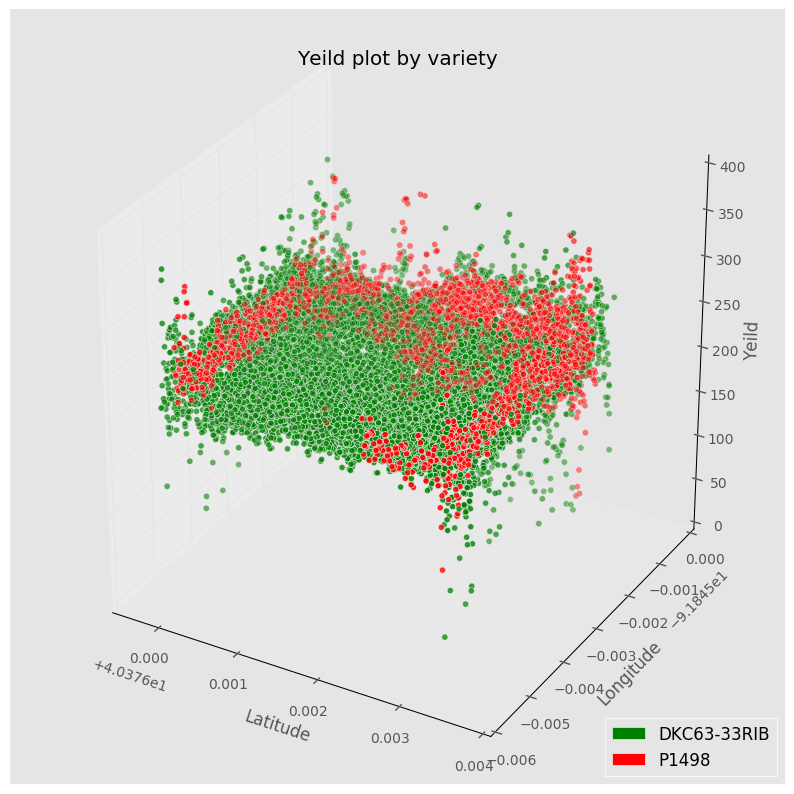

In [12]:
plot_harvest_variety(harvest_mapped)

Creating dummy variables for variety to enable Linear regression on categorical variables. 

In [77]:
dummy_ranks = pd.get_dummies(harvest_mapped['variety'], prefix='variety')


In [18]:
hdf = pd.concat([harvest_mapped, dummy_ranks], axis=1)
hdf.head()

,long,lat,yield,variety,seeding_rate,seed_spacing,speed,variety_DKC63-33RIB,variety_P1498
0,-91.849991,40.376097,88.451156,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
1,-91.849992,40.376106,102.173517,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
2,-91.849992,40.376116,191.420756,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
3,-91.849992,40.376127,236.556217,DKC63-33RIB,37.0791,5.639,3.58,1.0,0.0
4,-91.849993,40.376139,224.822367,DKC63-33RIB,37.0791,5.639,3.74,1.0,0.0


Creating a linear regression model for predicting yields from indicator variables. 

In [19]:
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn import linear_model

In [45]:
X = hdf[['seeding_rate', 'seed_spacing', 'speed', 'variety_P1498']]
y = hdf['yield']
#train, test = train_test_split(X, test_size = 0.2)
print(X.shape)

(16626, 4)


In [50]:
regr = linear_model.LinearRegression()
regr.fit(X, y)
print(regr.coef_)

[ 0.31619827 -1.00993664  1.92062679 -3.94220868]


Looking at the coefficients of the model we can see that the single largest predictor of yield is variety. After that seed spacing is negatively correlated with yield

In [47]:
hdf.loc[hdf['variety_P1498']==1.0, 'yield'].mean()

226.51092590322062

In [48]:
hdf.loc[hdf['variety_P1498']==0.0, 'yield'].mean()

231.89317748174122

In [49]:
rmse = np.sqrt(np.mean((regr.predict(X) - hdf['yield'])**2))
print(rmse)

26.4866042689


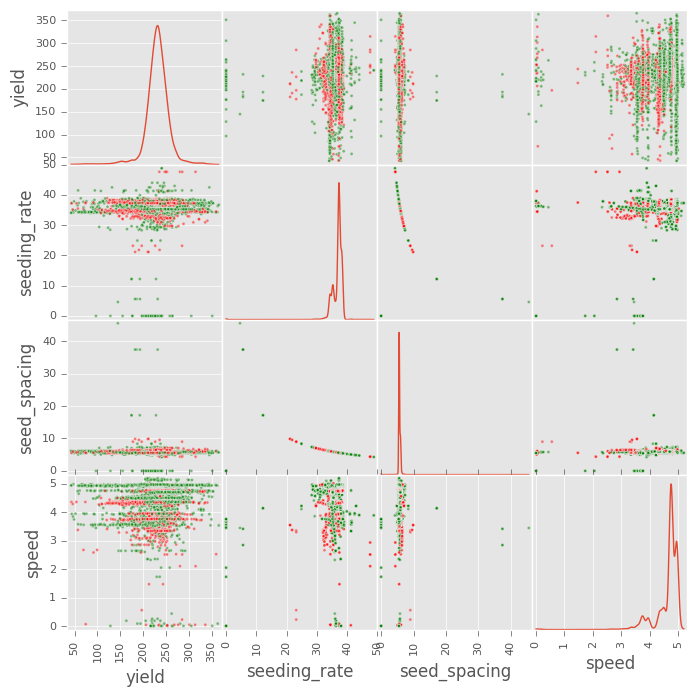

In [55]:
pd.tools.plotting.scatter_matrix(harvest_mapped[['yield', 'seeding_rate', 'seed_spacing', 'speed']], figsize=(8, 8), diagonal='kde', alpha=0.5, c=['r' if x=='P1498' else 'g' for x in harvest_mapped.variety])
plt.show()

In [60]:
hdf.head()

,long,lat,yield,variety,seeding_rate,seed_spacing,speed,variety_DKC63-33RIB,variety_P1498
0,-91.849991,40.376097,88.451156,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
1,-91.849992,40.376106,102.173517,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
2,-91.849992,40.376116,191.420756,DKC63-33RIB,37.0791,5.639,3.56,1.0,0.0
3,-91.849992,40.376127,236.556217,DKC63-33RIB,37.0791,5.639,3.58,1.0,0.0
4,-91.849993,40.376139,224.822367,DKC63-33RIB,37.0791,5.639,3.74,1.0,0.0


In [70]:
train, test = train_test_split(hdf, test_size = 0.2)
cnames = ['seeding_rate', 'seed_spacing', 'speed', 'variety_P1498']
train.shape, test.shape

((13300, 9), (3326, 9))

Splitting the data into Training set and Test set to test the predictive power of Linear model

In [71]:
train_X = train[cnames]
train_y = train['yield']

test_X = test[cnames]
test_y = test['yield']

In [72]:
regr = linear_model.LinearRegression()
regr.fit(train_X, train_y)
print(regr.coef_)

[ 0.36909163 -0.92023582  1.88978456 -3.7062957 ]


In [73]:
train_rmse = np.sqrt(np.mean((regr.predict(train_X) - train_y)**2))

In [74]:
print(train_rmse)

26.1080404828


In [75]:
test_rmse = np.sqrt(np.mean((regr.predict(test_X) - test_y)**2))
test_rmse

27.952305923471581

To test potential non-linear relationships we add squared value columns for seeding space, seeding rate

In [87]:
train_X.head()

,seeding_rate,seed_spacing,speed,variety_P1498,sq_seeding_rate
16279,37.3481,5.5984,3.76,1.0,1394.880574
5344,38.2882,5.4609,4.95,0.0,1465.986259
738,37.6322,5.5561,4.75,0.0,1416.182477
2647,38.2142,5.4715,4.95,0.0,1460.325082
4213,37.3441,5.5990,4.93,0.0,1394.581805


In [88]:
train_X['sq_seeding_rate'] = train_X['seeding_rate']**2
train_X['sq_speed_spacing'] = train_X['seed_spacing'] ** 2

test_X['sq_seeding_rate'] = test_X['seeding_rate'] ** 2
test_X['sq_speed_spacing'] = test_X['seed_spacing'] ** 2

/home/vagrant/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/vagrant/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/vagrant/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [89]:
train_X.head()

,seeding_rate,seed_spacing,speed,variety_P1498,sq_seeding_rate,sq_speed_spacing
16279,37.3481,5.5984,3.76,1.0,1394.880574,31.342083
5344,38.2882,5.4609,4.95,0.0,1465.986259,29.821429
738,37.6322,5.5561,4.75,0.0,1416.182477,30.870247
2647,38.2142,5.4715,4.95,0.0,1460.325082,29.937312
4213,37.3441,5.5990,4.93,0.0,1394.581805,31.348801


In [92]:
cnames = ['seeding_rate', 'seed_spacing', 'speed', 'variety_P1498', 'sq_seeding_rate', 'sq_speed_spacing']
regr = linear_model.LinearRegression()
regr.fit(train_X, train_y)
print(regr.coef_)

[ 0.87504458 -1.68996587  1.84389823 -3.78204437 -0.00962908  0.01659062]


Very small coefficients for the squared variables indicates the absence of a non-linear relationship between seeding rate and seed spacing 

To conclude, a linear model seems like a best fit for predicting yields and the difference in rmse error is not large between training and test set in the case without the squared columns. Also adding squared values of columns does not help in predicting yields significanltly as the get small coefficients. Further analysis to confirm this hypothsis would be ANOVA to understand the sources of variance in yields. 